# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Обучение модели LogisticRegression (DistilBERT)

1. Подготовка

In [1]:
!pip install transformers
!pip install eli5

     |████████████████████████████████| 4.0 MB 5.8 MB/s 
     |████████████████████████████████| 880 kB 37.8 MB/s 
     |████████████████████████████████| 596 kB 26.5 MB/s 
     |████████████████████████████████| 6.6 MB 32.0 MB/s 
     |████████████████████████████████| 77 kB 5.3 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=52a8ebd7eea314560a7d23ac52e7798cef8837fb2edf025427726e703c934fa4
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 106 kB 4.8 MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import eli5
from tqdm import notebook

#для обработки текста
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#для построения моделей
from sklearn.model_selection import train_test_split
import torch
import transformers as ppb
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


2. Загрузка и изучение данных

In [3]:
# Выведем данные:
data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
#data = data[:5000]
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
# Выведем число положительных и негативных комментариев:
data['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

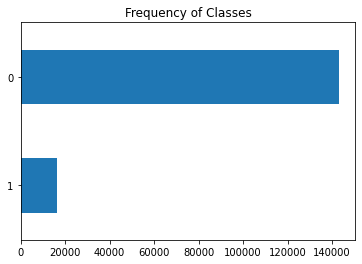

In [5]:
# Изобразим на графике число положительных и негативных комментариев:
data["toxic"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

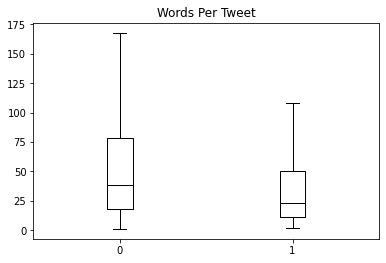

In [6]:
# Изобразим на графике число слова на один твит:
data["Words Per Tweet"] = data["text"].str.split().apply(len)
data.boxplot("Words Per Tweet", by="toxic", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

3. Обучим модель DistilBERT

In [7]:
# Загрузим обученную модель DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer
                                                    , 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
# Преобразуем текст в номера токенов, ограничив их длину: 
%%time
tokenized = data['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)))

CPU times: user 5min 38s, sys: 1.73 s, total: 5min 40s
Wall time: 5min 43s


In [9]:
# Применим метод padding, чтобы после токенизации длины исходных текстов в корпусе были равными:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
np.array(padded).shape

(159571, 512)

In [10]:
# Cоздадим маску для действительно важных токенов, то есть укажем нулевые и не нулевые значения:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(159571, 512)

In [11]:
torch.cuda.is_available()

True

In [12]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [13]:
start_time = time.time()
from tqdm import notebook
batch_size = 2 # для примера возьмем такой батч, где будет всего две строки датасета
embeddings = [] 
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
          model.to(device)
          batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy()) # перевод обратно на проц, чтобы в нумпай кинуть
        del batch
        del attention_mask_batch
        del batch_embeddings

features = np.concatenate(embeddings)
end_time = time.time()
time_LR_BERT = end_time - start_time

  0%|          | 0/79785 [00:00<?, ?it/s]

In [14]:
# Выделим целевые признаки:
labels = data['toxic']
labels = labels[:159570]
features.shape, labels.shape

((159570, 768), (159570,))

4. Обучим логистическую модель на данных после трансформации DistilBERT

In [15]:
# Разделим данные на тренировочную и тестовую выборки:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.1, random_state=42)

In [16]:
# Выведем размеры полученных выборок:
sample = train_features, test_features, train_labels, test_labels

for i in sample:
    display(i.shape)

(143613, 768)

(15957, 768)

(143613,)

(15957,)

In [17]:
# Обучим модель LogisticRegression:
lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(train_features, train_labels)

LogisticRegression(random_state=42)

In [18]:
# Протестируем модель на тестовой выборке:
predict = lr_clf.predict(test_features)
f1_LR_BERT = f1_score(test_labels, predict)
print('F1 score LogisticRegression:', f1_LR_BERT)

F1 score LogisticRegression: 0.7362906042612644


## Обучение моделей, используя Logistic Regression(tf-idf) и Naive Bayes(tf-idf)

**1. Обработка текста**

In [19]:
#Создадим фукнцию для корректировки текста:
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# Уберем stopword:
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#Лематизация
wl = WordNetLemmatizer()
 
# Функция для создания тегов NTLK
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Токенизация текста
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string))
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(a)

In [20]:
# Применим созданные функции для обработки текста:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
    
data['clean_text'] = data['text'].apply(lambda x: finalpreprocess(x))
data.head()

,text,toxic,Words Per Tweet,clean_text
0,Explanation\nWhy the edits made under my usern...,0,43,explanation edits make username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,17,aww match background colour seemingly stuck th...
2,"Hey man, I'm really not trying to edit war. It...",0,42,hey man really try edit war guy constantly rem...
3,"""\nMore\nI can't make any real suggestions on ...",0,113,make real suggestion improvement wonder sectio...
4,"You, sir, are my hero. Any chance you remember...",0,13,sir hero chance remember page


**2. Обучение и тестирование моделей**

In [21]:
#Разделим датасет на тренировочный и тестовый:
X_train, X_test, y_train, y_test = train_test_split(data["clean_text"],data["toxic"],test_size=0.2,shuffle=True)

In [22]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [23]:
#Обучение классификационной модели Logistic Regression(tf-idf):
start_time = time.time()
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train) 
end_time = time.time()
time_LR_TD = end_time - start_time 

In [24]:
# Выведем самые главные фичи:
eli5.show_weights(estimator=lr_tfidf, 
                  feature_names= list(tfidf_vectorizer.get_feature_names()),
                 top=(15,15))

Weight?,Feature
+33.906,fuck
+20.428,shit
+19.813,idiot
+19.566,bitch
+18.037,as
+17.952,asshole
+17.779,bullshit
+17.655,suck
+16.980,stupid
+15.512,faggot


In [25]:
#Предсказание:
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
print(classification_report(y_test,y_predict))
f1_LR_TD = f1_score(y_test,y_predict)
print('F1 score для Logistic Regression(tf-idf):', f1_LR_TD)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28660
           1       0.89      0.71      0.79      3255

    accuracy                           0.96     31915
   macro avg       0.93      0.85      0.88     31915
weighted avg       0.96      0.96      0.96     31915

F1 score для Logistic Regression(tf-idf): 0.7905705500512469


In [26]:
#Обучение классификационной модели Naive Bayes(tf-idf)
start_time = time.time()
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)
time_LR_NB = end_time - start_time   

In [27]:
#Предсказание:
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
f1_LR_NB = f1_score(y_test,y_predict)
print('F1 score для Naive Bayes(tf-idf):', f1_LR_NB)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28660
           1       1.00      0.22      0.36      3255

    accuracy                           0.92     31915
   macro avg       0.96      0.61      0.66     31915
weighted avg       0.93      0.92      0.90     31915

F1 score для Naive Bayes(tf-idf): 0.36084549572219426


In [28]:
# Соберем полученные данные в единую таблицу:
metrics = pd.DataFrame({'model':['LogisticRegression with BERT', 'LogisticRegression with TfidfVectorizer', 'MultinomialNB with TfidfVectorizer'],
                       'F1':[f1_LR_BERT, f1_LR_TD, f1_LR_NB],
                        'Time to fit':[time_LR_BERT, time_LR_TD, time_LR_NB]})

display(metrics.sort_values(by=['F1'], ascending=False).reset_index(drop=True))

,model,F1,Time to fit
0,LogisticRegression with TfidfVectorizer,0.790571,3.830821
1,LogisticRegression with BERT,0.736291,5667.442259
2,MultinomialNB with TfidfVectorizer,0.360845,-0.363606


## Выводы

* Лучшая метрика F1 у модели LogisticRegression с TfidfVectorizer - 79.
* На имеющихся данных лучше себя показала модификация данных через TfidfVectorizer.